# lesson-4

### Библиотеки:

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

plt.rcParams["figure.figsize"] = (10,5)

### Программа из методички

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1, random_state=5)

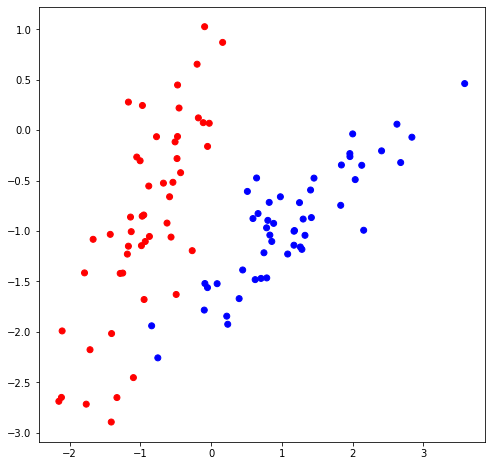

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
#Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [14]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [15]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [16]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [17]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [18]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [19]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [20]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

<ipython-input-21-76f9302d78af>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-21-76f9302d78af>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=100.00')

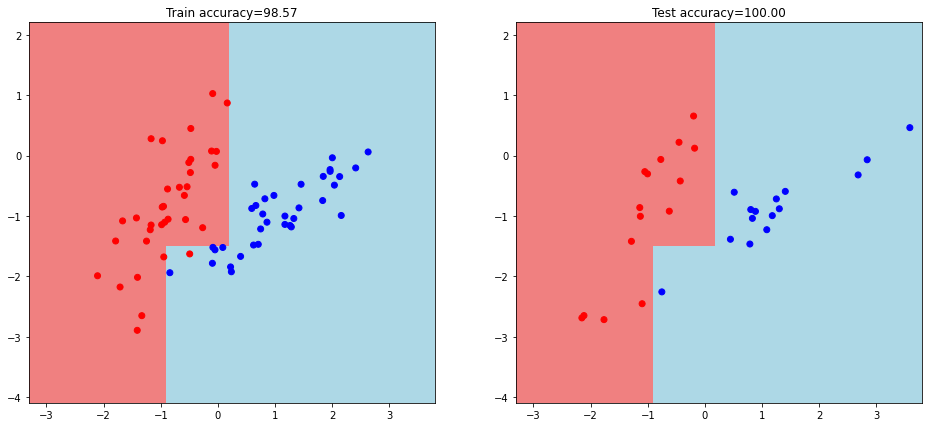

In [21]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

### 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

Перепишем функции нахождения лучшего разбиения и построения дерева:

In [22]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_samples_leaf, max_features, random_state):
    
    #  обозначим минимальное количество объектов в узле
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    if max_features is not None:
        random.seed(random_state)
        index_futures = random.sample(range(data.shape[1]), max_features)
    else:
        index_futures = range(data.shape[1])
    
    for index in index_futures:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_samples_leaf объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [23]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_depth = None, max_features = None, min_samples_split = 2, 
               min_samples_leaf = 1, random_state = 42):
    
    #  Прекращаем рекурсию, когда достигнута глубина дерева max_depth
    if max_depth is not None:
        if max_depth == 0:
            return Leaf(data, labels)
        else:
            max_depth -= 1
    
    #  Прекращаем рекурсию, когда количество выборок для разбиения меньше min_samples_split
    if len(labels) < min_samples_split:
        return Leaf(data, labels)

    quality, t, index = find_best_split(data, labels, min_samples_leaf, max_features, random_state)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_depth, max_features, min_samples_split, 
                             min_samples_leaf, random_state)
    false_branch = build_tree(false_data, false_labels, max_depth, max_features, min_samples_split, 
                              min_samples_leaf, random_state)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Попробуем различные настройки дерева:

#### max_depth = 2:

In [24]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_depth = 2)

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [25]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.85714285714286

In [26]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

<ipython-input-27-91ad2d50fe22>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-27-91ad2d50fe22>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=96.67')

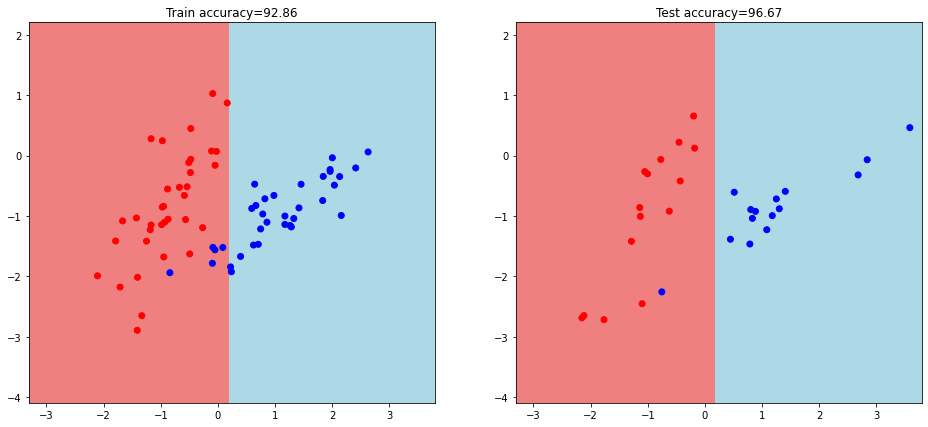

In [27]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [28]:
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Прогноз: 0
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


#### max_depth = 3:

In [29]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_depth = 3)

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [30]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [31]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

<ipython-input-32-91ad2d50fe22>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-32-91ad2d50fe22>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=100.00')

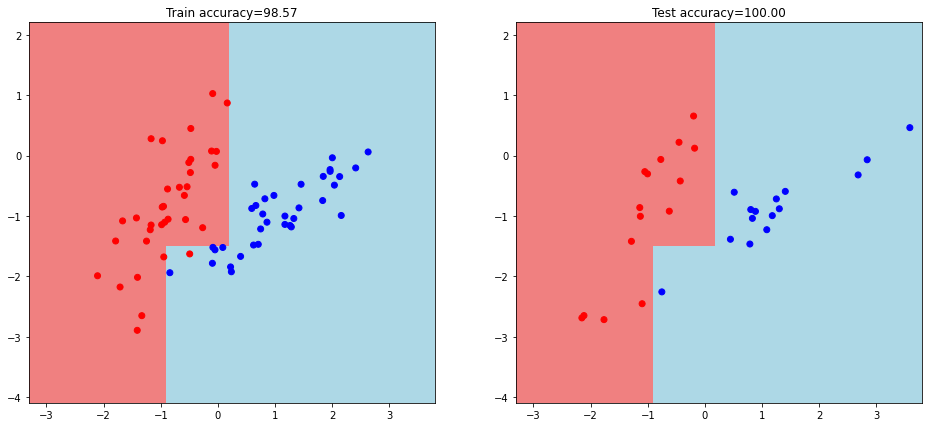

In [32]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [33]:
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


#### max_depth = 5:

In [34]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_depth = 5)

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [35]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

100.0

In [36]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

<ipython-input-37-91ad2d50fe22>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-37-91ad2d50fe22>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=96.67')

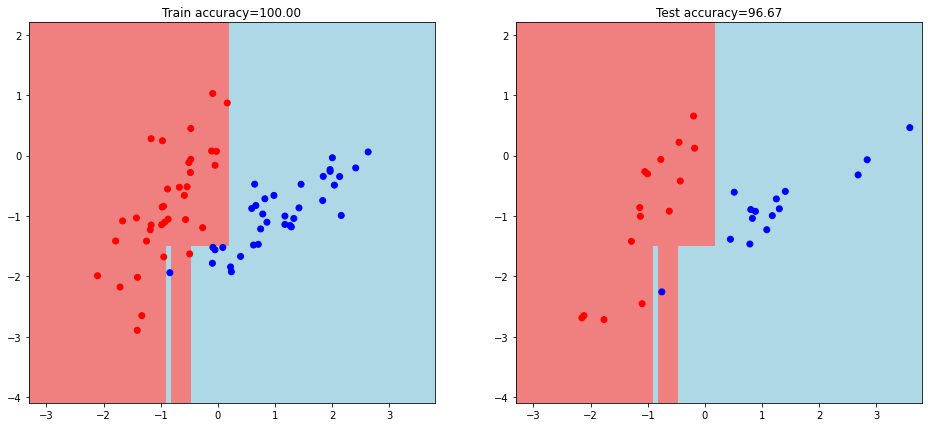

In [37]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [38]:
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.4942656820712277
      --> True:
        Индекс 0
        Порог -0.8411814419026544
        --> True:
          Прогноз: 1
        --> False:
          Прогноз: 0
      --> False:
        Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


#### Вывод: max_depth = 2 - дерево недообучилось, max_depth = 3 - оптимальное значение, max_depth = 5 - дерево переобучилось.

#### min_samples_split = 2:

In [39]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, min_samples_split = 2)

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [40]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

100.0

In [41]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

<ipython-input-42-91ad2d50fe22>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-42-91ad2d50fe22>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=96.67')

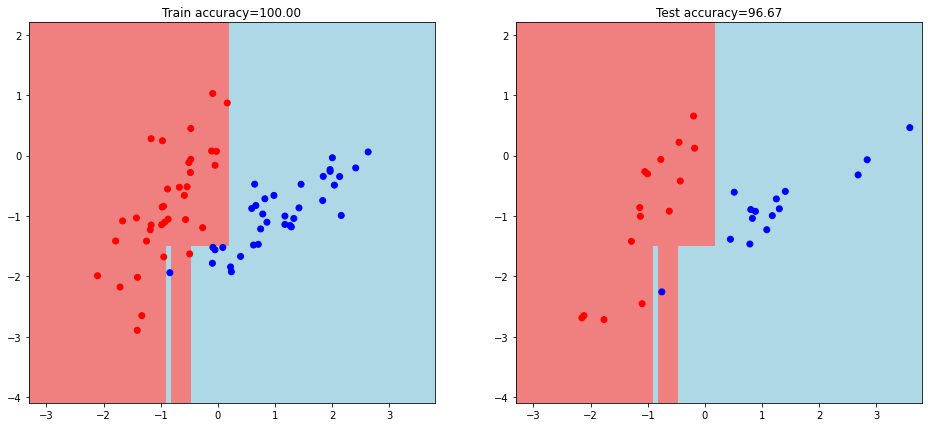

In [42]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [43]:
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.4942656820712277
      --> True:
        Индекс 0
        Порог -0.8411814419026544
        --> True:
          Прогноз: 1
        --> False:
          Прогноз: 0
      --> False:
        Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


#### min_samples_split = 3:

In [44]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, min_samples_split = 3)

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [45]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [46]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

<ipython-input-47-91ad2d50fe22>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-47-91ad2d50fe22>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=100.00')

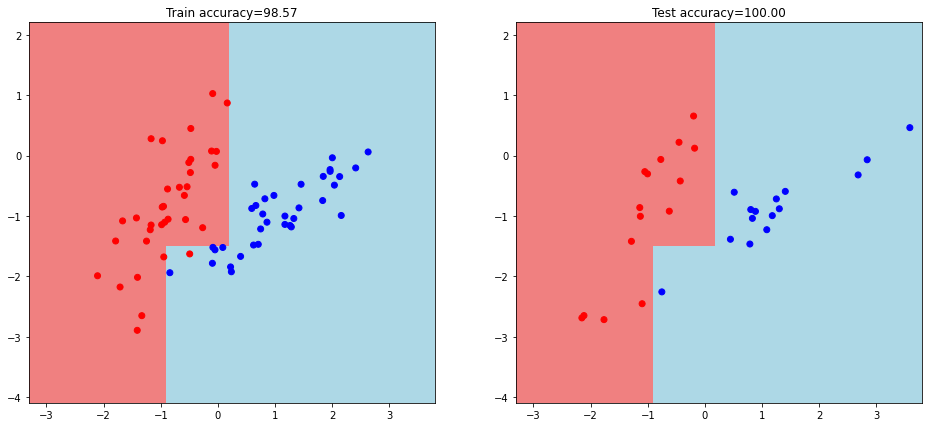

In [47]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [48]:
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.4942656820712277
      --> True:
        Прогноз: 1
      --> False:
        Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


#### min_samples_split = 20:

In [49]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, min_samples_split = 20)

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [50]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.85714285714286

In [51]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

<ipython-input-52-91ad2d50fe22>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-52-91ad2d50fe22>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=96.67')

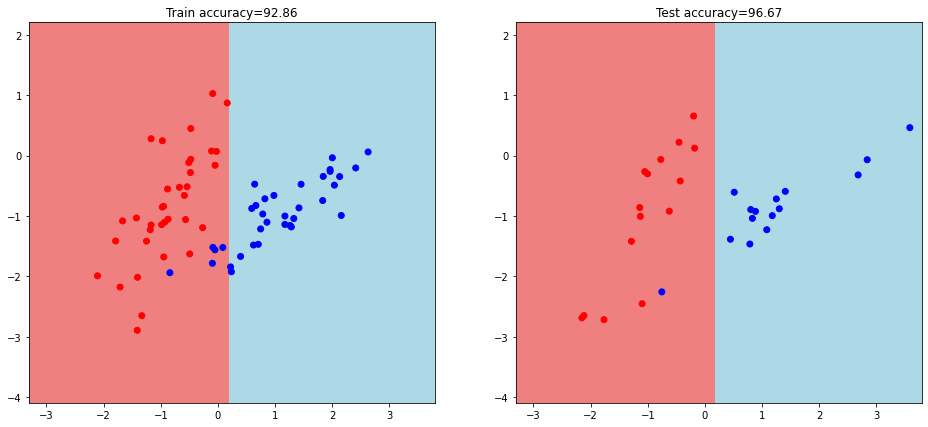

In [52]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [53]:
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Прогноз: 0
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


#### Вывод: min_samples_split = 2 - дерево переобучилось, min_samples_split = 3 - оптимальное значение, min_samples_split = 20 - дерево недообучилось.

#### min_samples_leaf = 1:

In [54]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, min_samples_leaf = 1)

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [55]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

100.0

In [56]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

<ipython-input-57-91ad2d50fe22>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-57-91ad2d50fe22>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=96.67')

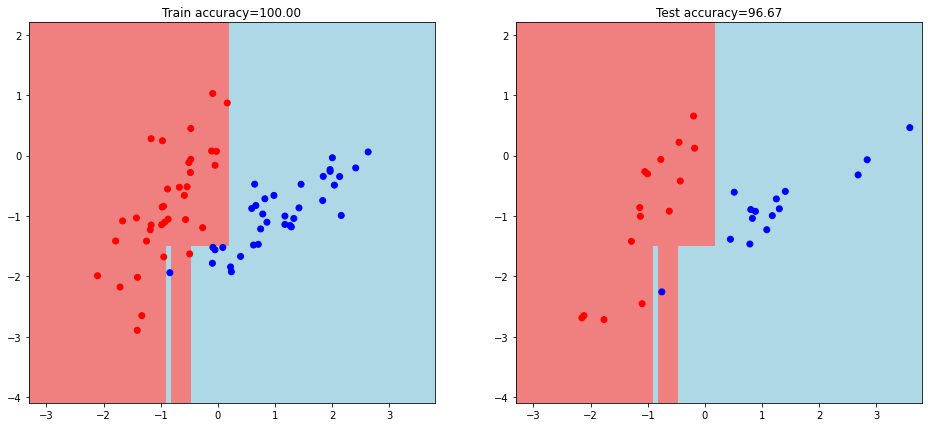

In [57]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [58]:
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.4942656820712277
      --> True:
        Индекс 0
        Порог -0.8411814419026544
        --> True:
          Прогноз: 1
        --> False:
          Прогноз: 0
      --> False:
        Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


#### min_samples_leaf = 5:

In [59]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, min_samples_leaf = 5)

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [60]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [61]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

<ipython-input-62-91ad2d50fe22>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-62-91ad2d50fe22>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=100.00')

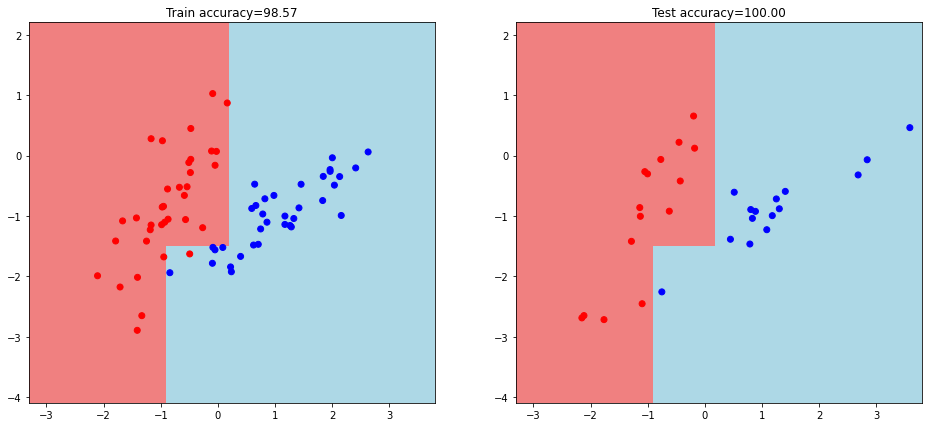

In [62]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [63]:
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


#### min_samples_leaf = 20:

In [64]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, min_samples_leaf = 20)

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [65]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.85714285714286

In [66]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

<ipython-input-67-91ad2d50fe22>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-67-91ad2d50fe22>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=96.67')

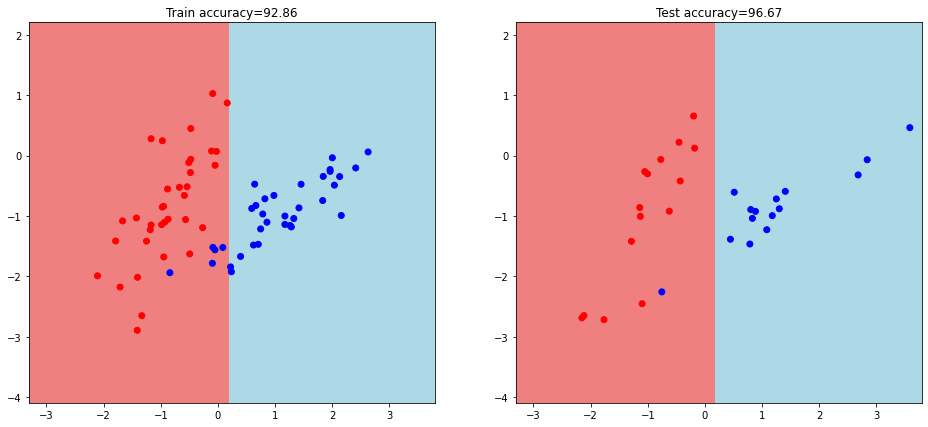

In [67]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [68]:
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 0
  Порог -0.8725985883473684
  --> True:
    Прогноз: 0
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


#### Вывод: min_samples_leaf = 1 - дерево переобучилось, min_samples_leaf = 5 - оптимальное значение, min_samples_leaf = 20 - дерево недообучилось.

### 2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

Перепишем функции связанные с расчетом качества:

In [69]:
# Расчет энтропии Шеннона

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log(p) / np.log(2)
        
    return impurity

In [70]:
# Расчет качества

def quality(left_labels, right_labels, current_criterion, criterion):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_criterion - p * criterion(left_labels) - (1 - p) * criterion(right_labels)

In [71]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_samples_leaf, max_features, random_state, criterion):
    
    #  обозначим минимальное количество объектов в узле
    
    current_criterion = criterion(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    if max_features is not None:
        random.seed(random_state)
        index_futures = random.sample(range(data.shape[1]), max_features)
    else:
        index_futures = range(data.shape[1])
    
    for index in index_futures:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_samples_leaf объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_criterion, criterion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [72]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_depth = None, max_features = None, criterion = gini, min_samples_split = 2, 
               min_samples_leaf = 1, random_state = 42):
    
    #  Прекращаем рекурсию, когда достигнута глубина дерева max_depth
    if max_depth is not None:
        if max_depth == 0:
            return Leaf(data, labels)
        else:
            max_depth -= 1
    
    #  Прекращаем рекурсию, когда количество выборок для разбиения меньше min_samples_split
    if len(labels) < min_samples_split:
        return Leaf(data, labels)

    quality, t, index = find_best_split(data, labels, min_samples_leaf, max_features, random_state, criterion)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_depth, max_features, criterion, min_samples_split, 
                             min_samples_leaf, random_state)
    false_branch = build_tree(false_data, false_labels, max_depth, max_features, criterion, min_samples_split, 
                              min_samples_leaf, random_state)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [73]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, min_samples_leaf = 5, criterion = entropy)

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [74]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [75]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

<ipython-input-76-91ad2d50fe22>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-76-91ad2d50fe22>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=100.00')

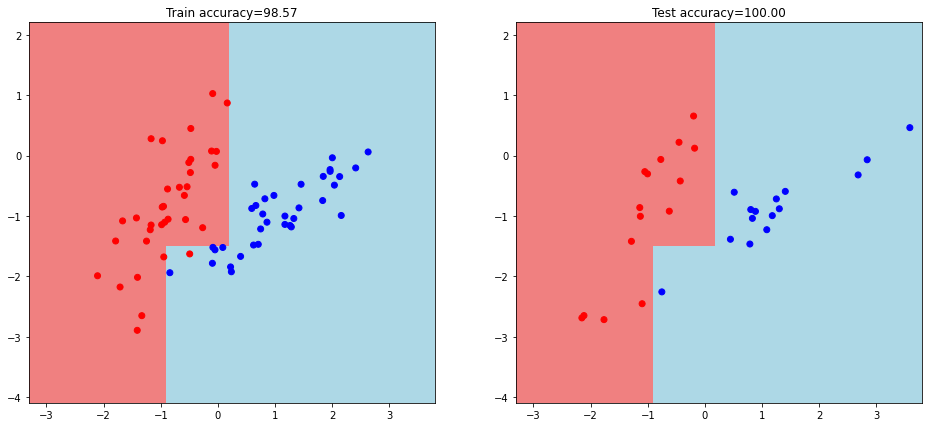

In [76]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [77]:
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


#### Вывод: оба критерия информативности отработали отлично, разницы в выборе критерия для данного датасета нету.

### 3 [опция]. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [78]:
# сгенерируем данные
regression_data, regression_labels = datasets.make_regression(n_features = 2, n_informative = 2, random_state=5)

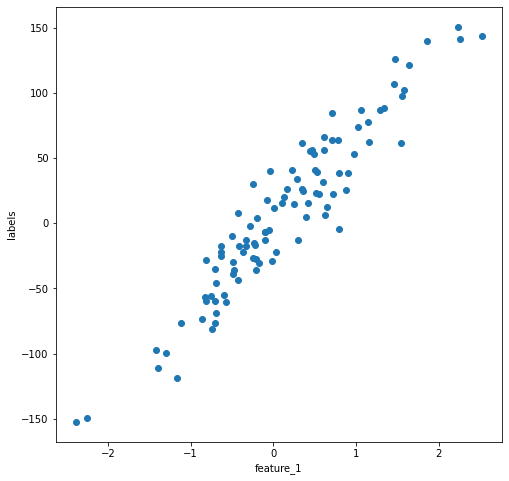

In [79]:
# визуализируем сгенерированные данные по первому признаку

plt.figure(figsize=(8,8))
plt.xlabel('feature_1')
plt.ylabel('labels')
plt.scatter(list(map(lambda x: x[0], regression_data)), regression_labels)

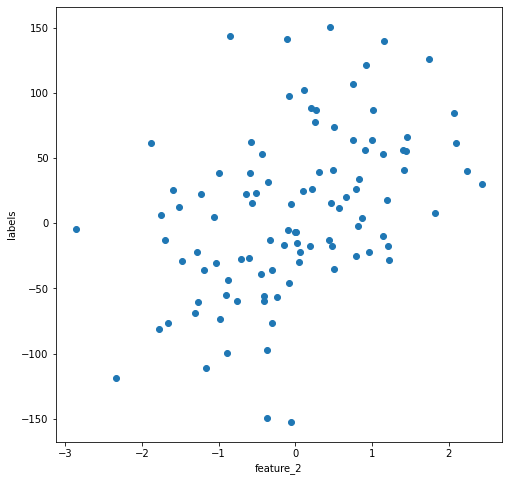

In [80]:
# визуализируем сгенерированные данные по второму признаку

plt.figure(figsize=(8,8))
plt.xlabel('feature_2')
plt.ylabel('labels')
plt.scatter(list(map(lambda x: x[1], regression_data)), regression_labels)

Перепишем некоторые функции под задачу регрессии:

In [81]:
# Класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = np.mean(self.labels) 

In [82]:
# Расчет дисперсии

def dispersion(labels):
    return np.var(labels)

In [83]:
#Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(regression_data, 
                                                                                     regression_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [84]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, criterion = dispersion)

# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [85]:
# Введем функцию подсчета r2 метрики

def r2_metric(y, y_pred):
    loss = sum((y - y_pred)**2)
    return 1 - loss / sum((y - np.mean(y))**2)

In [86]:
# Точность на обучающей выборке
train_r2 = r2_metric(train_labels, train_answers)
train_r2

1.0

In [87]:
# Точность на тестовой выборке
test_r2 = r2_metric(test_labels, answers)
test_r2

0.9147480101918668

Text(0.5, 1.0, 'Test r2=0.91')

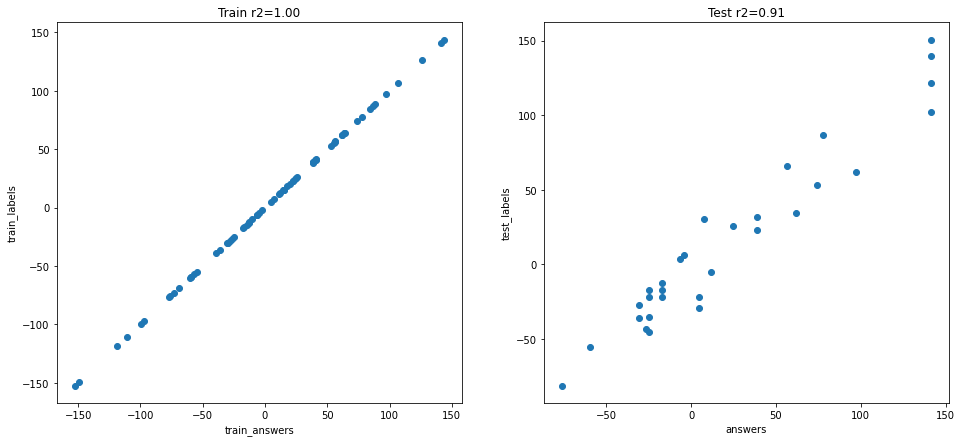

In [88]:
plt.figure(figsize = (16, 7))

# график предсказаний на обучающей выборки
plt.subplot(1,2,1)
plt.xlabel('train_answers')
plt.ylabel('train_labels')
plt.scatter(train_answers, train_labels)
plt.title(f'Train r2={train_r2:.2f}')

# график предсказаний на тестовой выборки
plt.subplot(1,2,2)
plt.xlabel('answers')
plt.ylabel('test_labels')
plt.scatter(answers, test_labels)
plt.title(f'Test r2={test_r2:.2f}')

In [89]:
print_tree(my_tree)

Индекс 0
Порог -0.10061434630710828
--> True:
  Индекс 0
  Порог -0.8568531547160899
  --> True:
    Индекс 0
    Порог -2.2491181284434787
    --> True:
      Индекс 0
      Порог -2.386697744379377
      --> True:
        Прогноз: -152.49936131427688
      --> False:
        Прогноз: -149.66624361859945
    --> False:
      Индекс 0
      Порог -1.167278449710173
      --> True:
        Индекс 1
        Порог -1.164701910115395
        --> True:
          Индекс 0
          Порог -1.3970740246682614
          --> True:
            Прогноз: -110.81020877241555
          --> False:
            Прогноз: -118.56057513568012
        --> False:
          Индекс 0
          Порог -1.4219245490984462
          --> True:
            Прогноз: -97.34193416486161
          --> False:
            Прогноз: -99.4655679805966
      --> False:
        Индекс 0
        Порог -1.1184064312813717
        --> True:
          Прогноз: -76.66978594690195
        --> False:
          Прогноз: -73.0387607859

Лучший результат на тесте, когда полное переобучение дерева. min_samples_split = 2, min_samples_leaf = 1.